In [18]:
import sys
sys.path.append("../classes")
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE, Isomap, MDS, SpectralEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import numpy as np, pandas as pd
from scipy.cluster import hierarchy
from sklearn.metrics import homogeneity_completeness_v_measure

from geno_classifier import *

from itertools import starmap, product
import re
import GEOparse
from random import randint
import seaborn as sns; sns.set(color_codes=True)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

import scipy

In [2]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}

cmap = mcolors.LinearSegmentedColormap('my_colormap', cdict, 100)

In [3]:
diseases = ['leukemia',
            'glioma',
            'cervical_cancer',
            'pancreatic_cancer',
            'endometriosis',
            'breast_cancer_2',
            'colon_cancer',
            'prostate_cancer',
            'colorectal_cancer',
            'oral_carcinoma',
            'brain_cancer',
            'renal_carcinoma',
            'esophageal_carcinoma',
            'autism',
            'diabetes',
            'psoriasis',
            'lung_cancer_1',
            'H1N1',
            'HBV']

In [4]:
change_lable = lambda label, prefix: '{}_{}'.format(prefix, label)
def get_cancer_dataframe(results_path, labels_path, label, diff=True, pathways=True):
    c_results = pickle.load(open(results_path,'rb'))
    try:
        c_labels_ = pickle.load(open(labels_path,'rb'))["y"]
    except TypeError:
        c_labels_ = pickle.load(open(labels_path,'rb'))
    cancer, cancer_y = preprocess_results(c_results, c_labels_, 
                                                use_diff_score=diff, use_pathways=pathways, 
                                                scale=False, use_one_hot=False)

#     cancer.index = starmap(change_lable, product(c_labels_, [label]))
    return cancer, c_labels_

In [5]:
def get_Xys(diseases):
    nodiffs = {"X":dict(), "y":dict()}
    diffs = {"X":dict(), "y":dict()}
    for i, disease in enumerate(diseases):
        try:
            Xno, yno = get_cancer_dataframe('../results/'+disease+'.results', '../datasets/'+disease+'_Xy', disease,
                                                                diff=False, pathways=False)
            X, y = get_cancer_dataframe('../results/'+disease+'.results', '../datasets/'+disease+'_Xy', disease,
                                                                diff=True, pathways=True)
        except FileNotFoundError:
            Xno, yno = get_cancer_dataframe('../results/'+disease+'.results', '../datasets/'+disease+'_y', disease,
                                                                diff=False, pathways=False)
            Xno, yno = get_cancer_dataframe('../results/'+disease+'.results', '../datasets/'+disease+'_y', disease,
                                                                diff=True, pathways=True)

        nodiffs["X"][disease] = Xno
        nodiffs["y"][disease] = yno
        
        diffs["X"][disease] = X
        diffs["y"][disease] = y
    
    return diffs, nodiffs

In [6]:
# diffs, nodiffs = get_Xys(diseases)
# pickle.dump(diffs, open("../datasets/Xy_diffs", 'wb'))
# pickle.dump(nodiffs, open("../datasets/Xy_nodiffs", 'wb'))    

In [7]:
def load_Xs(Xy_diffs_path="../datasets/Xy_diffs", Xy_nodiffs_path="../datasets/Xy_nodiffs", include_healthy=False): 
    X_diffs = pickle.load(open(Xy_diffs_path, 'rb'))["X"]
    X_nodiffs = pickle.load(open(Xy_nodiffs_path, 'rb'))["X"]
    def chose_label(x, disease):
        disease = re.sub("_"," ",re.sub("_\d"," ",disease)).strip()
        if include_healthy:
            return x
#             return x+"_"+disease
        else:
            return disease if "unhealthy" in x else np.NaN
    for X in [X_diffs, X_nodiffs]:
        for disease in diseases:
            X_diff = X[disease].reset_index()
            X_diff["index"] = X_diff["index"].apply(
                lambda x:chose_label(x, disease))
            X_diff.dropna(inplace=True)
            X[disease] = X_diff
    return X_diffs, X_nodiffs

In [8]:
X_diffs_h, X_nodiffs_h = load_Xs(include_healthy=True)

In [9]:
X_diffs, X_nodiffs = load_Xs()
Xs_ = pd.concat(X_diffs.values()).sample(frac=1).rename(columns={"index":"diseases"})

In [10]:
len(diseases), len(X_diffs), len(X_nodiffs)

(19, 19, 19)

In [11]:
disease_labels = Xs_.reset_index()["diseases"]
unique = disease_labels.unique()
colors = ['#%06X' % randint(0, 0xFFFFFF) for i in range(len(unique))]
lut = dict(zip(unique, colors))
lut_per_disease = {"healthy":"#4AA02C","unhealthy":"#8C001A"}

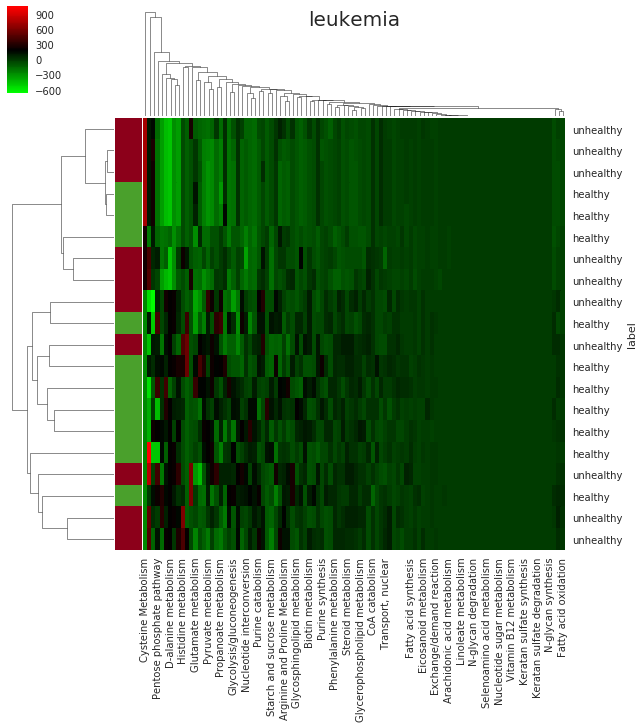

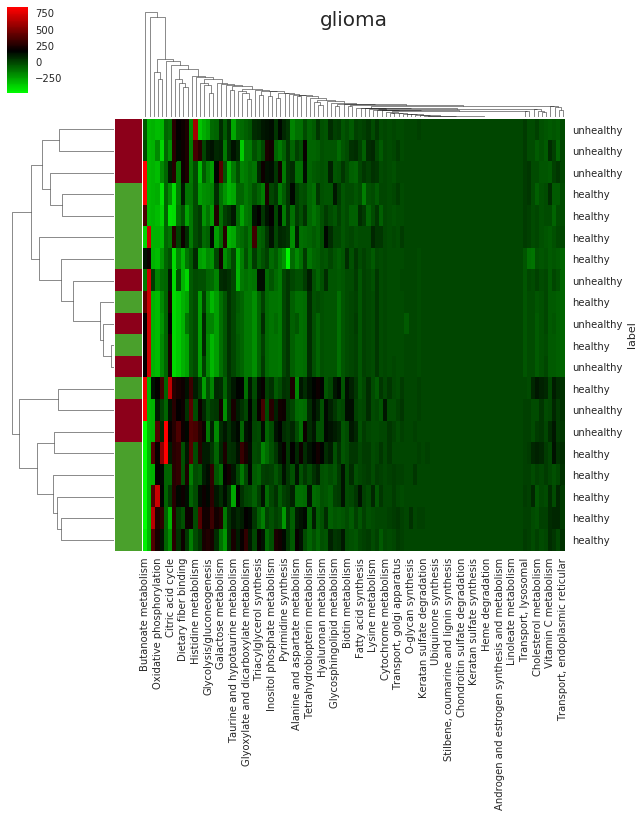

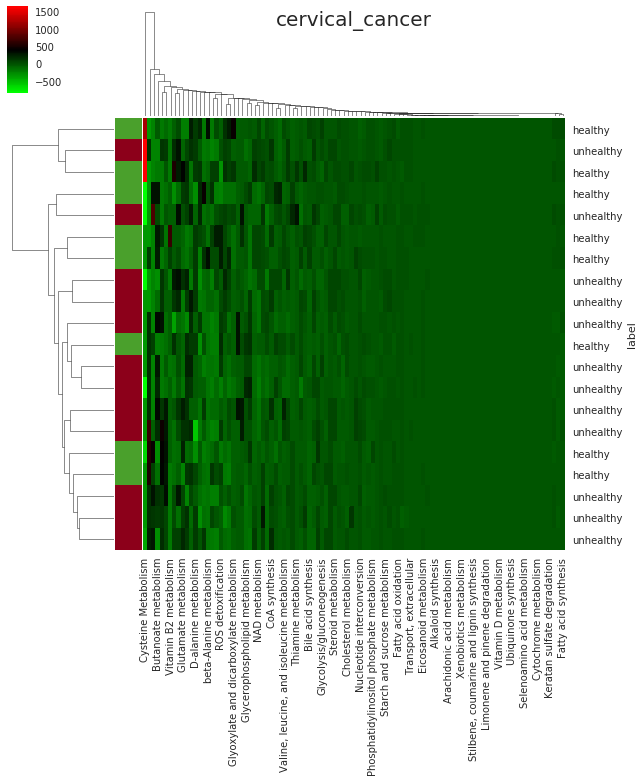

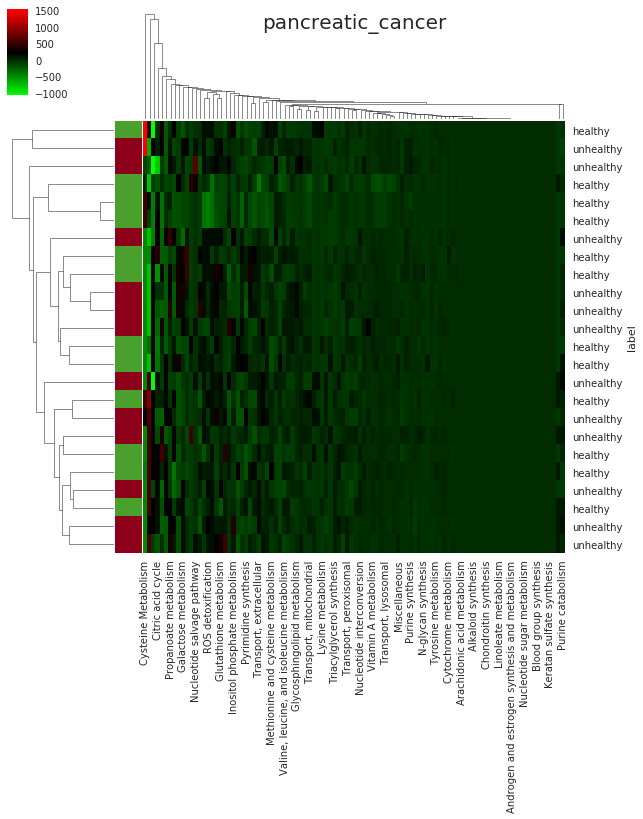

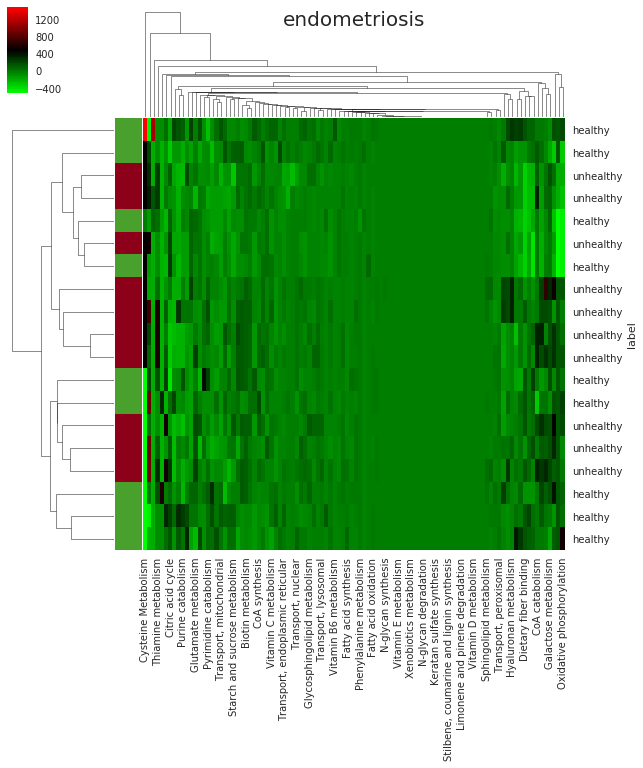

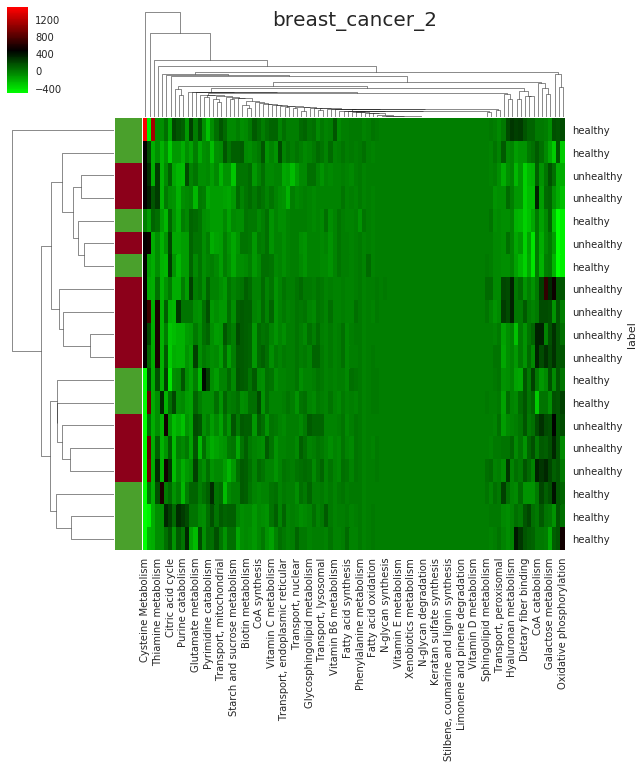

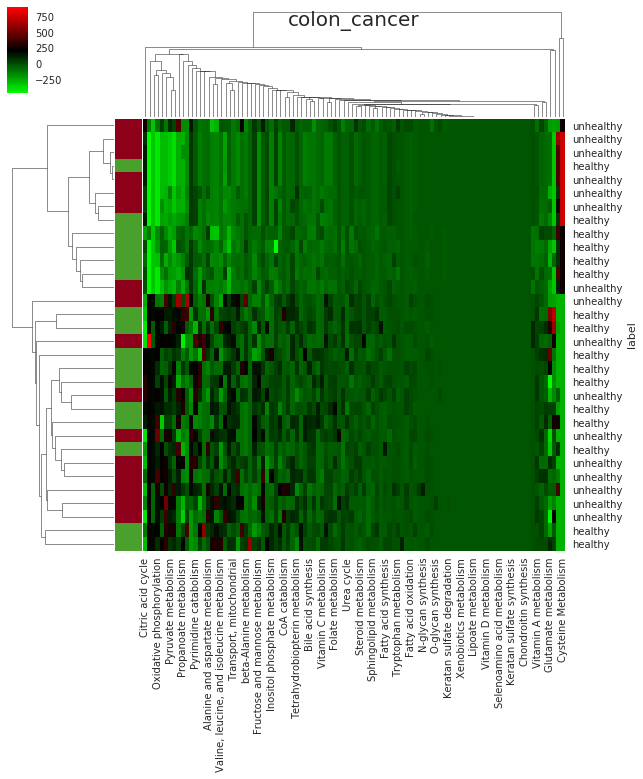

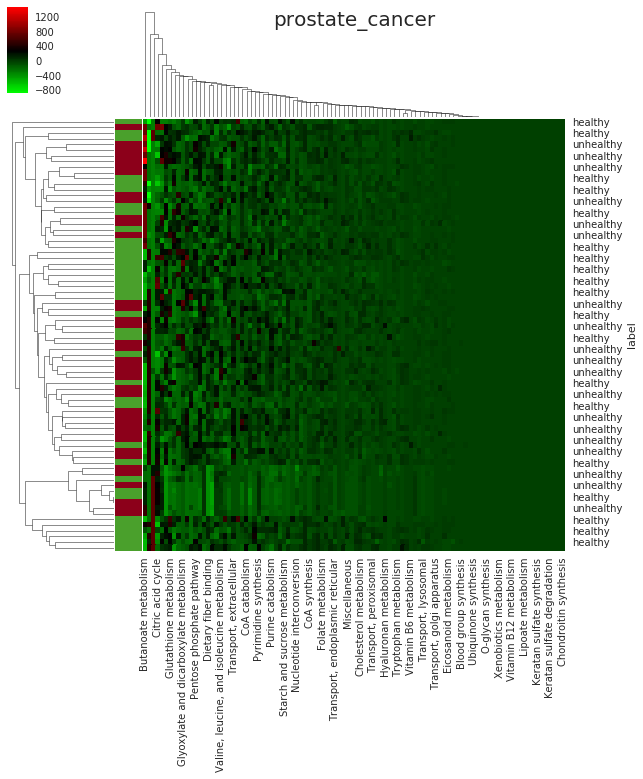

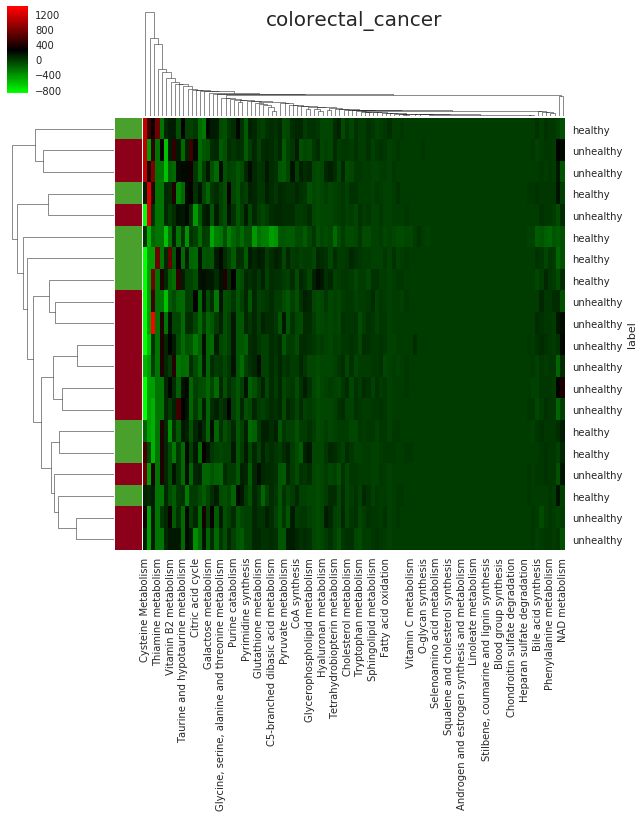

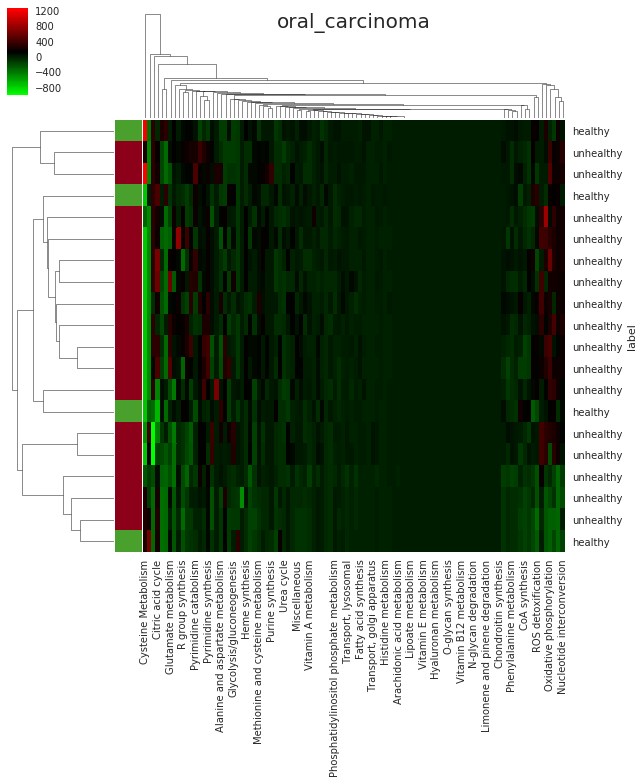

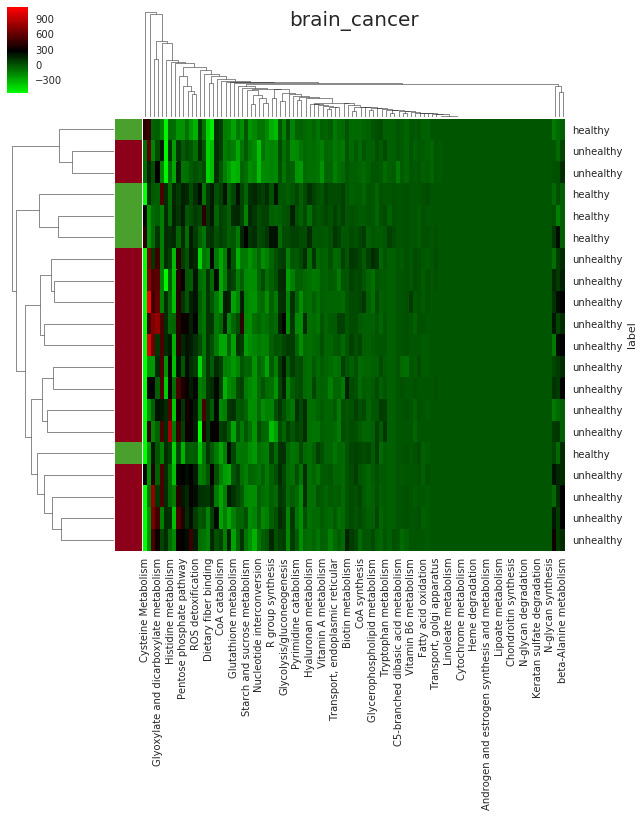

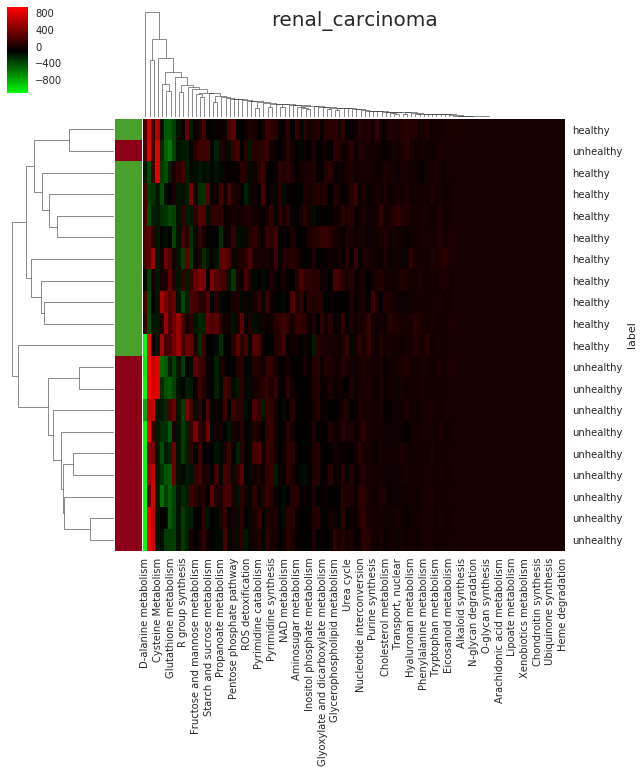

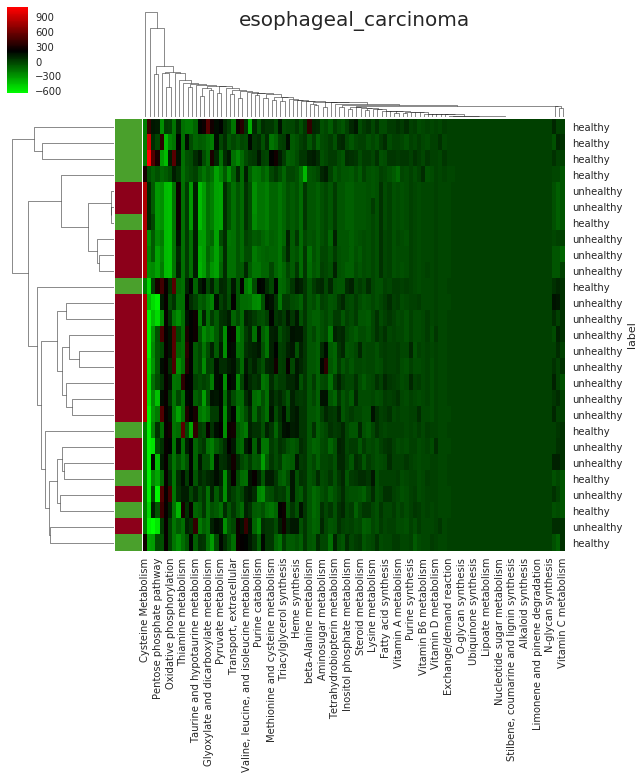

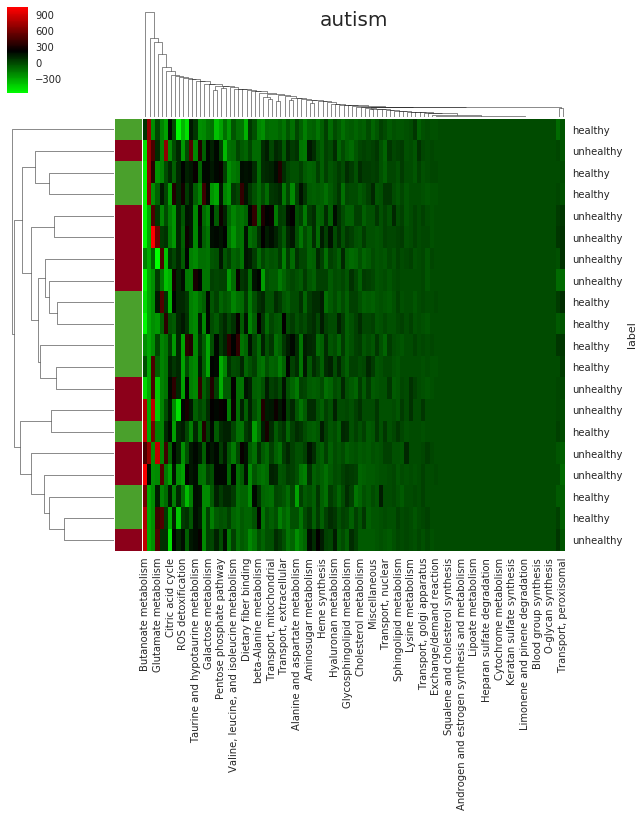

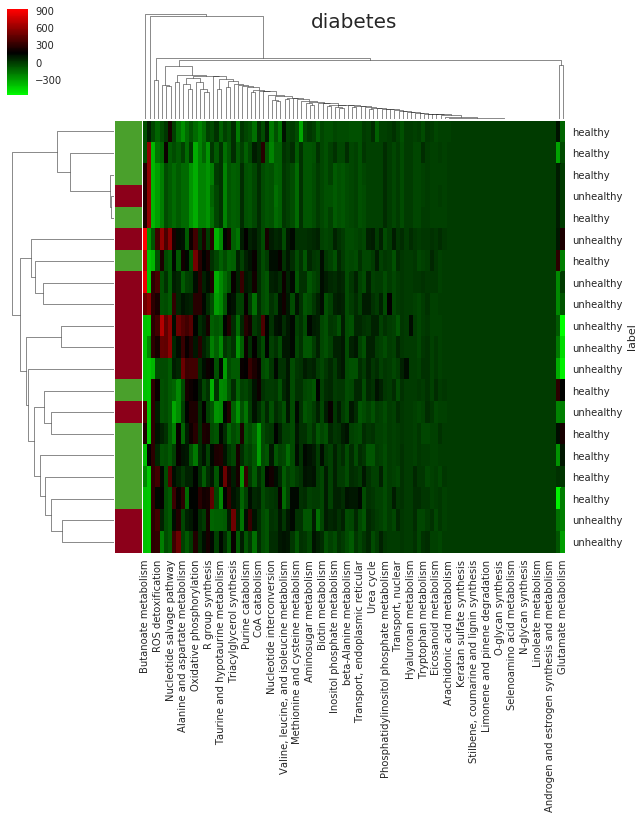

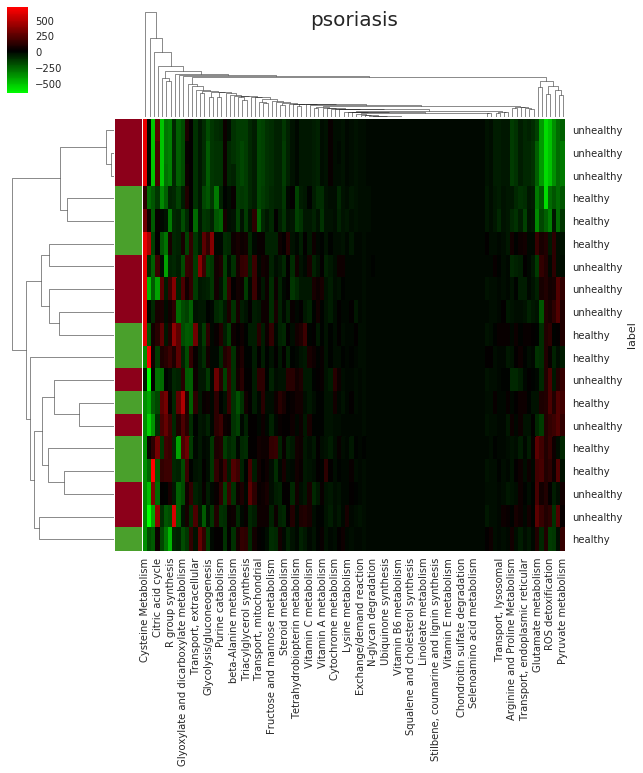

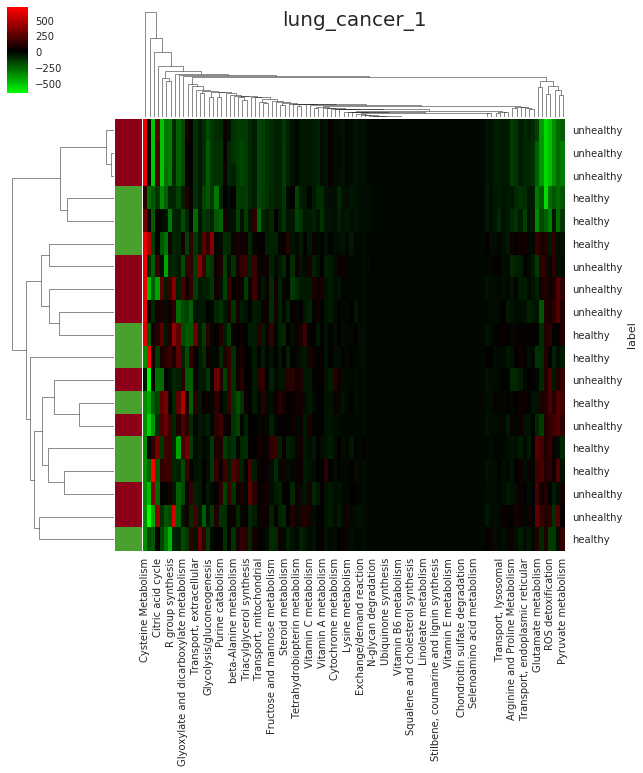

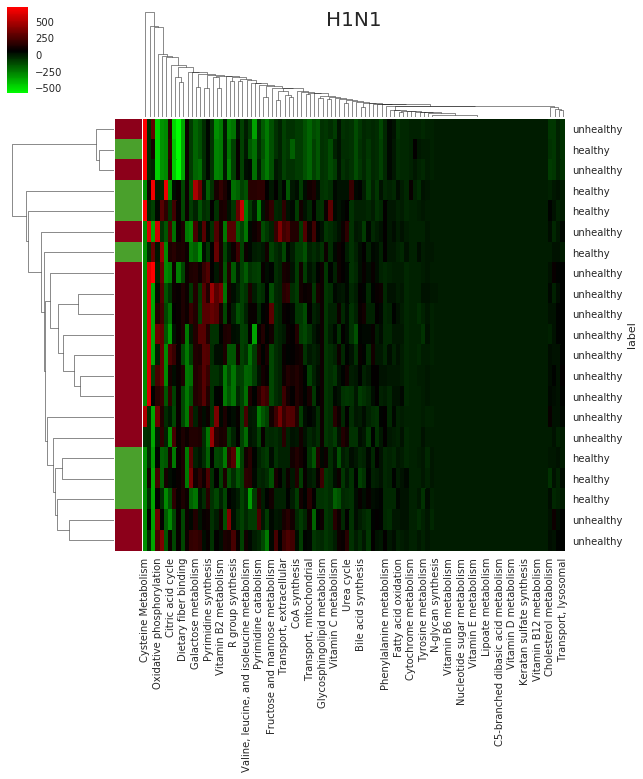

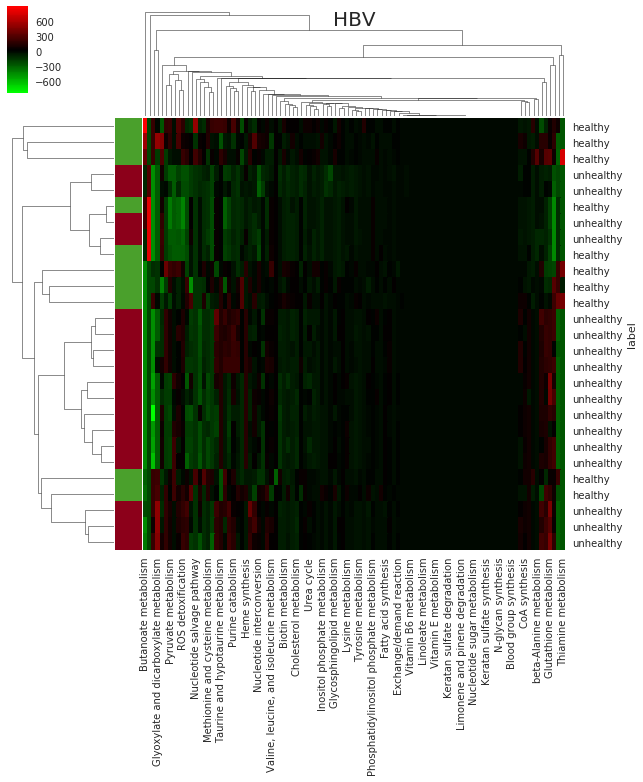

In [12]:
for disease in diseases:
    Xs = X_diffs_h[disease].rename(columns={"index":"label"})
    disease_labels = Xs["label"]
    Xs.set_index("label", inplace=True)
    row_colors = disease_labels.map(lut_per_disease)
    g = sns.clustermap(Xs, row_colors=list(row_colors), cmap=cmap)
    ax = g.ax_heatmap
    ax.set_title(disease, y=1.2, fontsize=20)

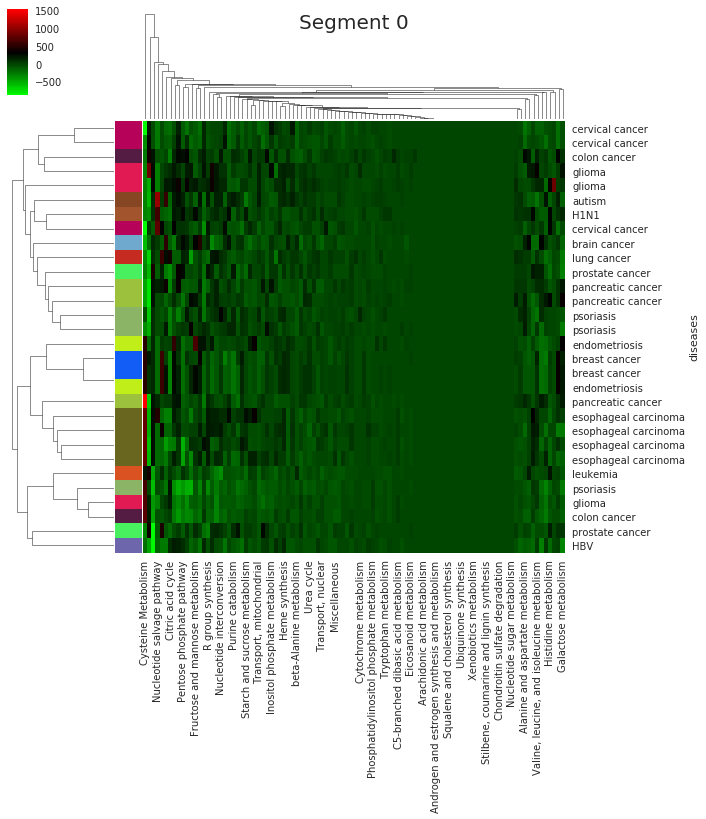

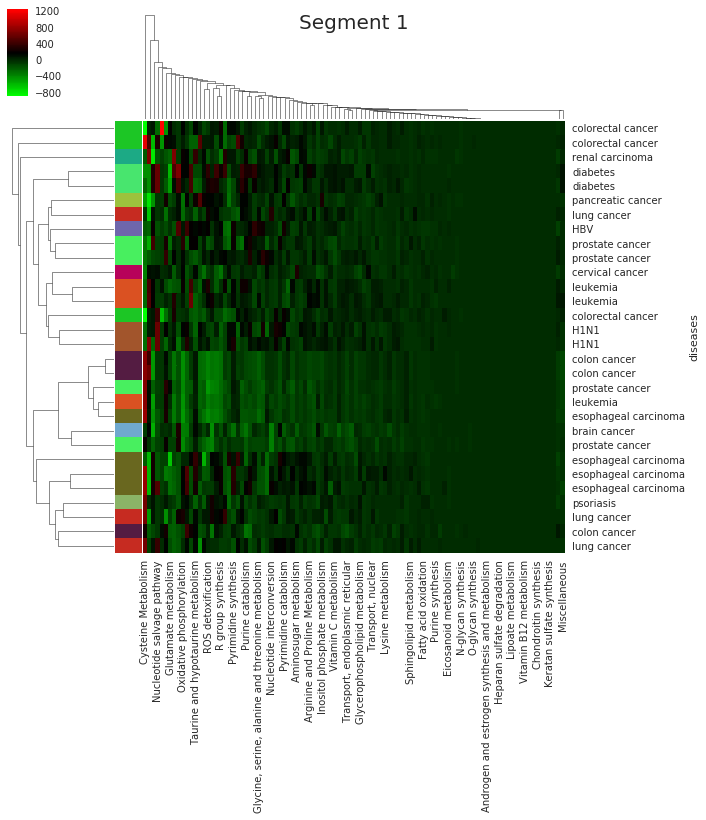

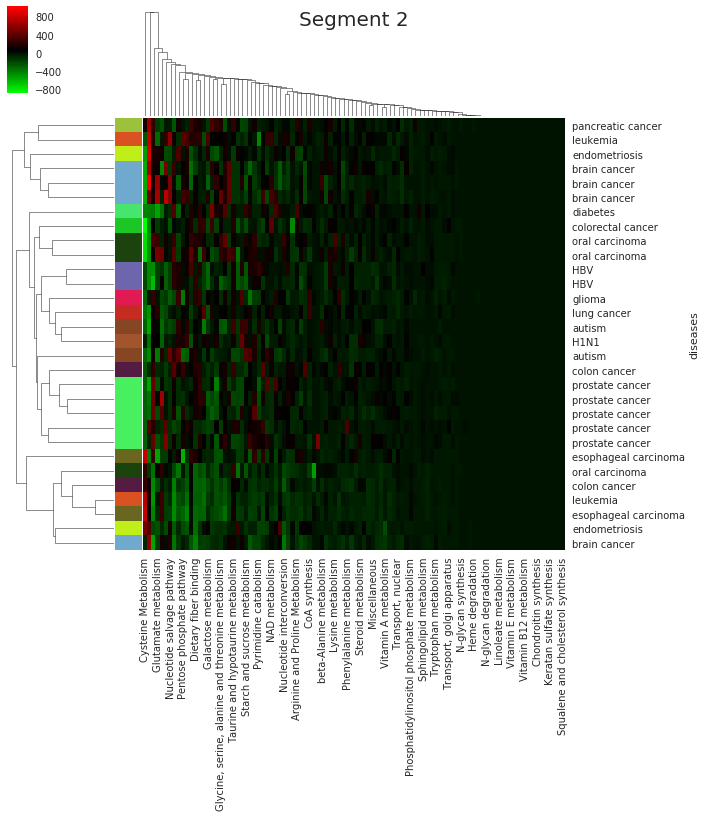

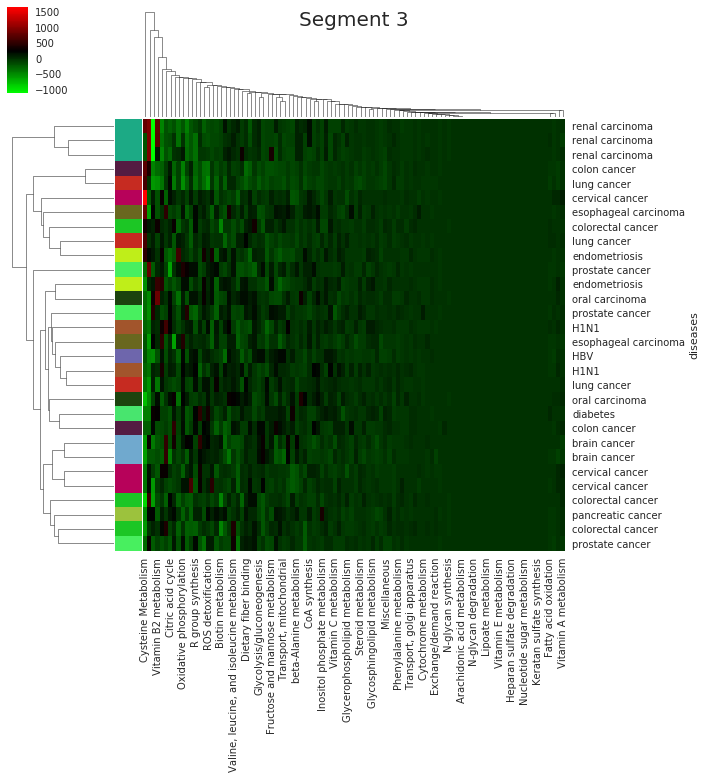

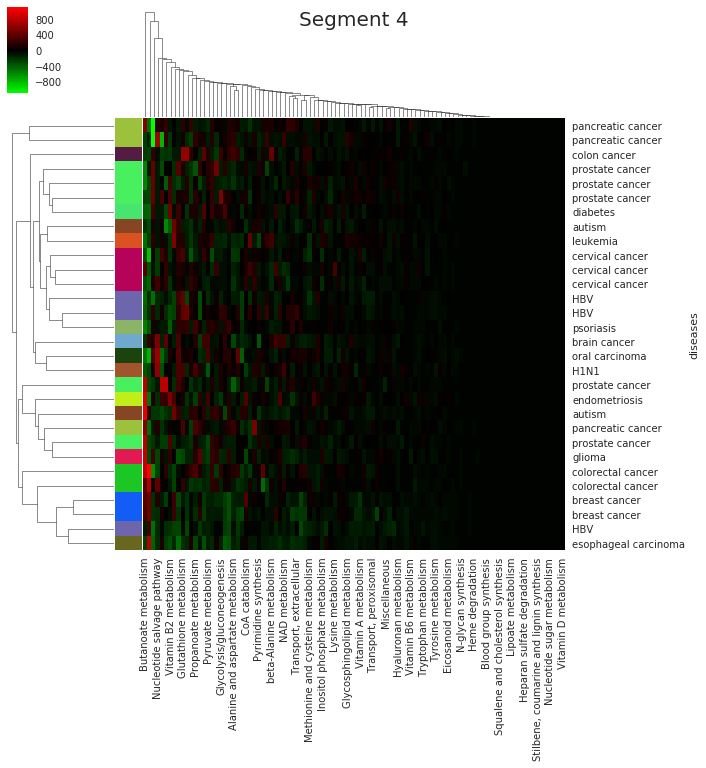

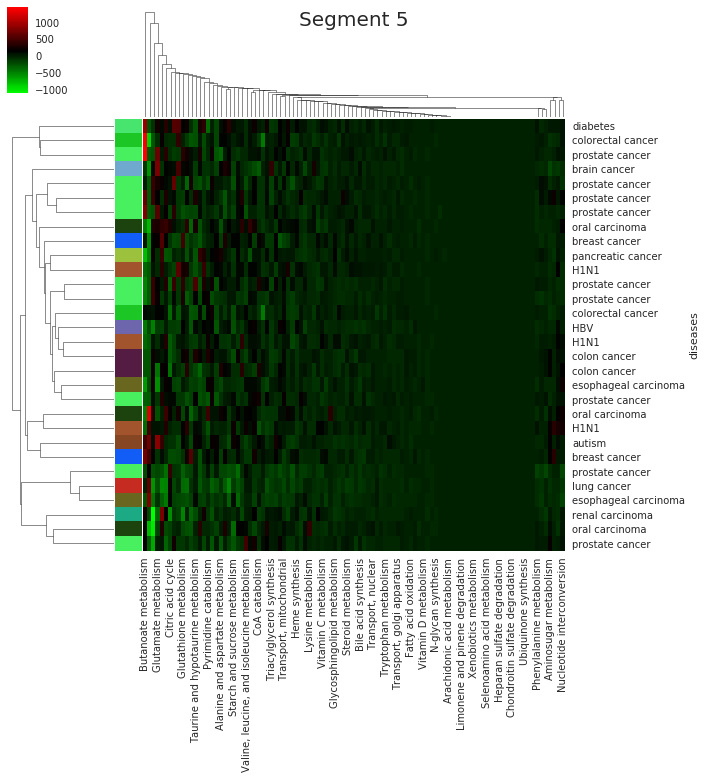

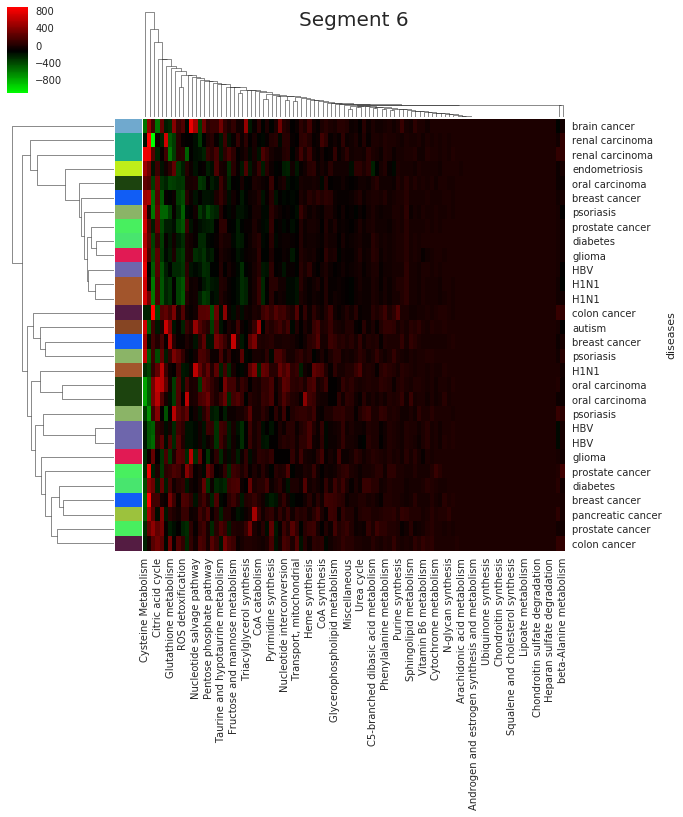

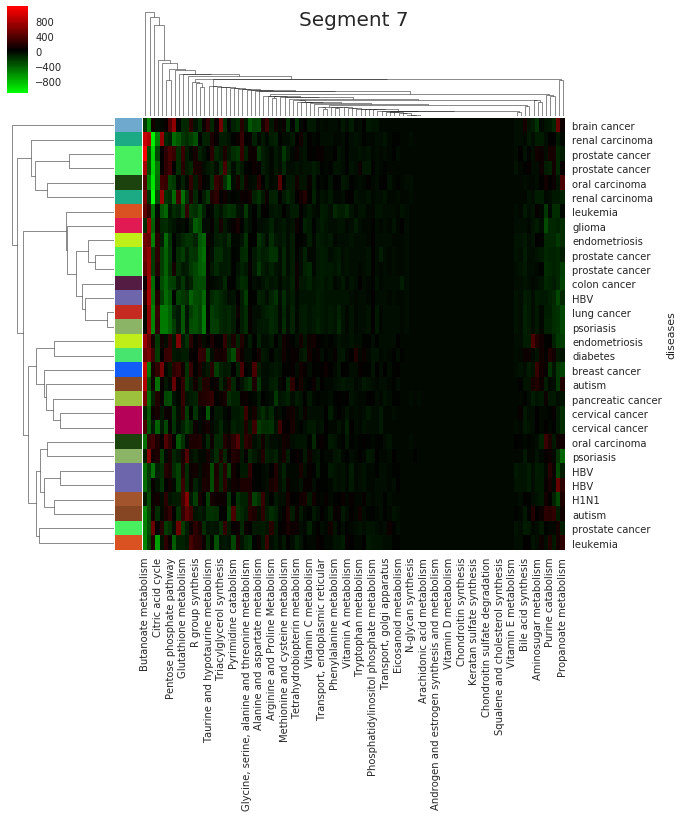

In [13]:
segments = max(int(len(Xs_)/20), 30)
for i in range(int(len(Xs_)/segments)):
    Xs = Xs_[i*segments:(i+1)*segments]
    disease_labels = Xs["diseases"]
    Xs.set_index("diseases", inplace=True)
    row_colors = disease_labels.map(lut)
    g = sns.clustermap(Xs, row_colors=list(row_colors), cmap=cmap)
    ax = g.ax_heatmap
    ax.set_title("Segment {}".format(i), y=1.2, fontsize=20)

In [14]:
Xs_.set_index("diseases", inplace=True)

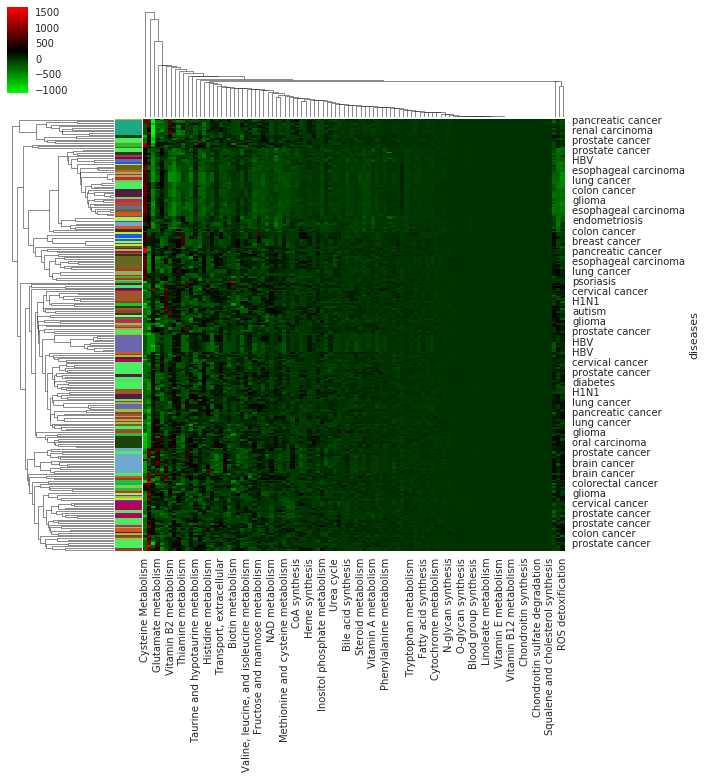

In [15]:
disease_labels = Xs_.reset_index()["diseases"]
row_colors = disease_labels.map(lut)
g = sns.clustermap(Xs_, row_colors=list(row_colors), cmap=cmap)

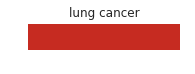

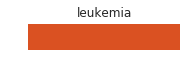

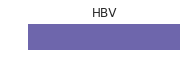

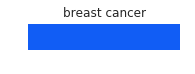

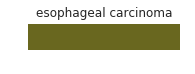

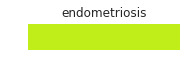

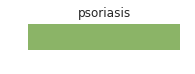

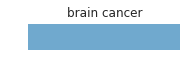

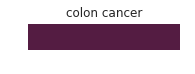

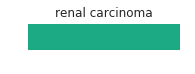

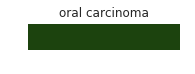

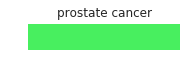

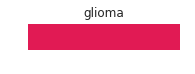

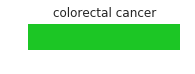

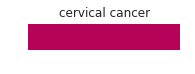

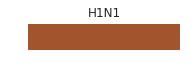

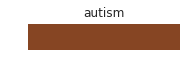

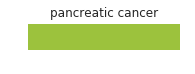

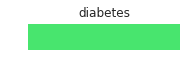

In [16]:
for disease, color in lut.items():
    plt.figure(figsize=(3,0.5))
    plt.bar([1],[1], color=color)
    plt.axis('off')
    plt.title(disease)

## Averaging pathways for each disease

In [19]:
Xs_averaged = Xs_.groupby(Xs_.index).mean()

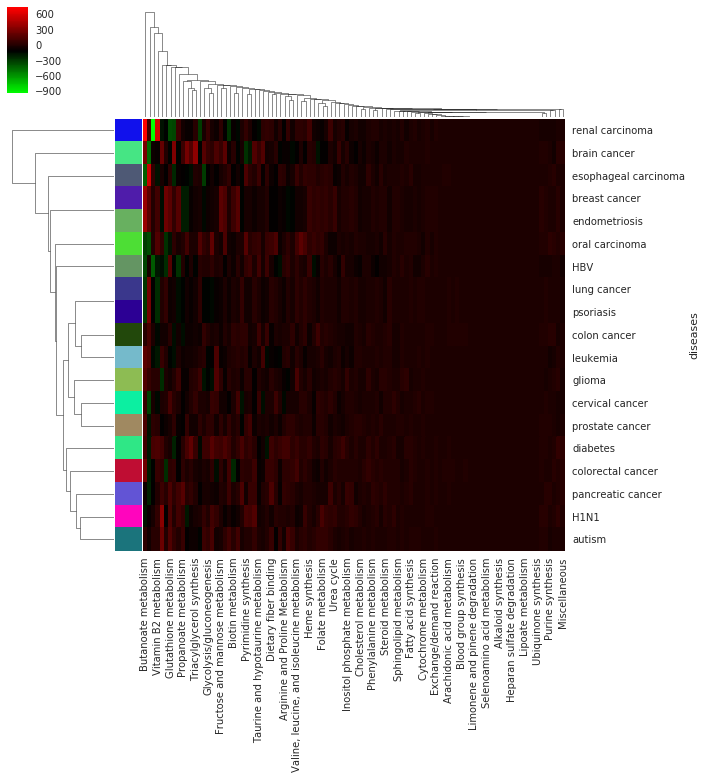

In [20]:
disease_labels = Xs_averaged.reset_index()["diseases"]
row_colors = disease_labels.map(lut)
g = sns.clustermap(Xs_averaged, row_colors=list(row_colors), cmap=cmap)

## Using only most significant 5 pathway

In [24]:
from sklearn.feature_selection import SelectKBest
skb = SelectKBest(k=5)
reduced_Xs_ = Xs_.copy()
all_columns = reduced_Xs_.columns
labels = list(reduced_Xs_.index)
skb.fit(reduced_Xs_, labels)
get_columns = lambda x: [i[0] for i in x]
selected_columns = get_columns(all_columns[np.argwhere(skb.get_support()==True)])
reduced_Xs = pd.DataFrame(skb.transform(reduced_Xs_), index=labels, columns=selected_columns)
reduced_Xs.head()

,Limonene and pinene degradation,Squalene and cholesterol synthesis,Triacylglycerol synthesis,Vitamin B12 metabolism,beta-Alanine metabolism
endometriosis,-4.678687e-06,-8.854493e-06,-117.451820,-4.427346e-06,-26.620375
pancreatic cancer,-8.511150e-06,-8.546274e-06,65.527380,-8.387865e-06,-27.777785
H1N1,-4.311017e-07,-4.851430e-07,94.182131,-2.424523e-07,-21.837181
psoriasis,6.882837e-06,6.883148e-06,-133.173572,6.882971e-06,-99.415705
breast cancer,-4.678870e-06,-8.854708e-06,-85.400538,-4.427346e-06,-26.620375


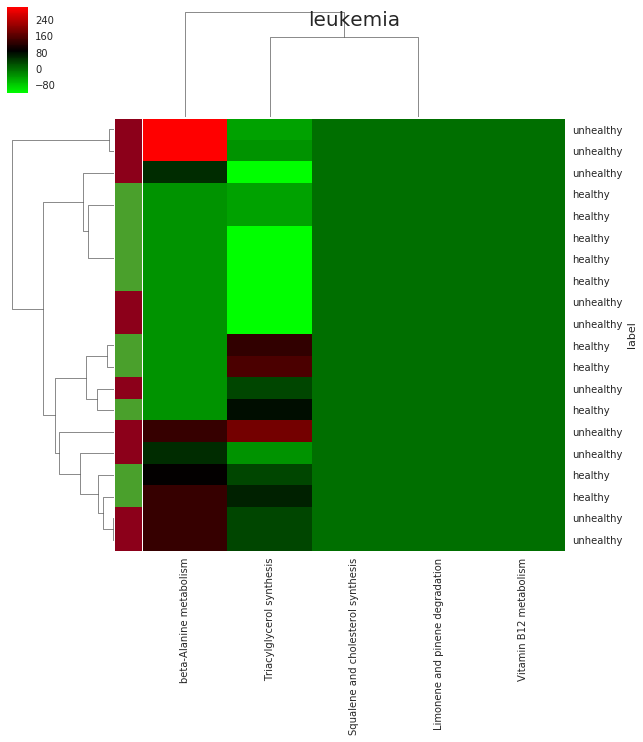

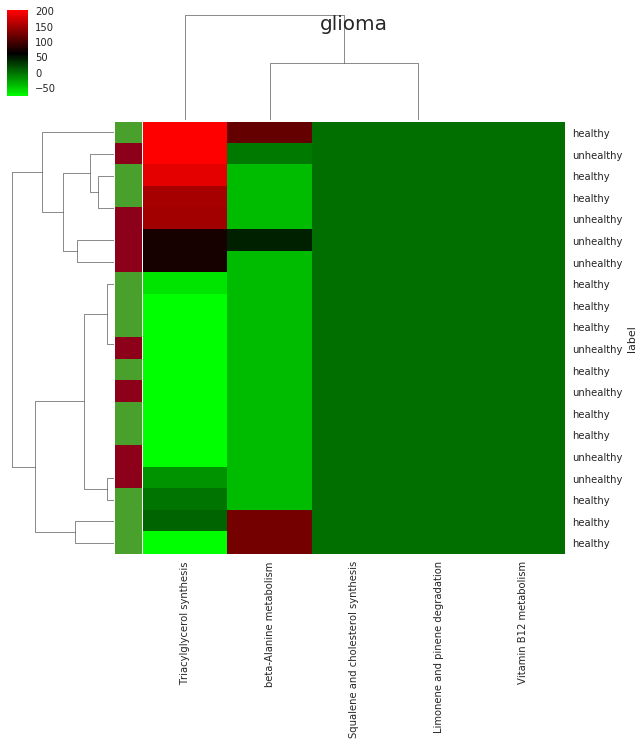

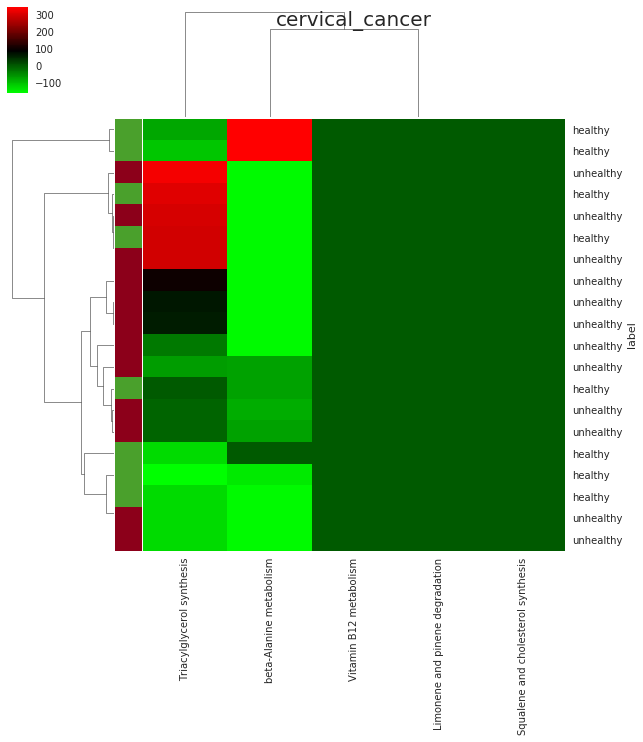

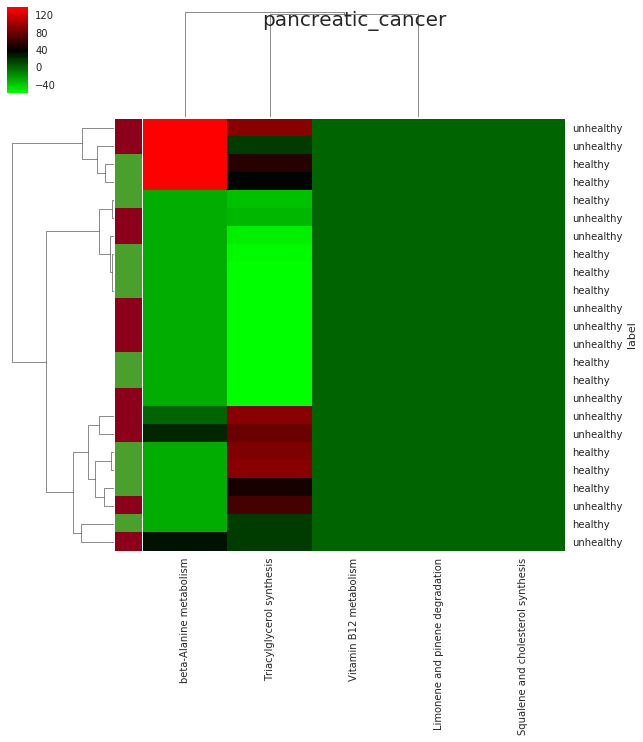

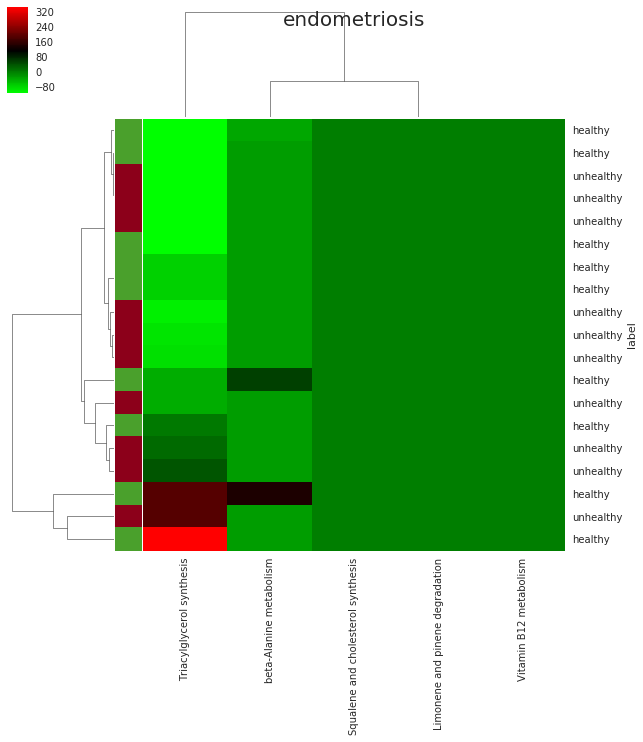

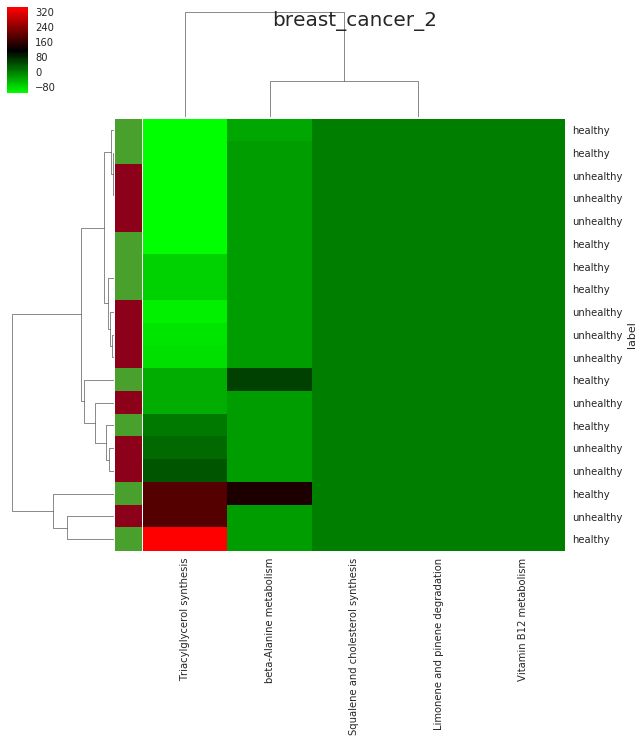

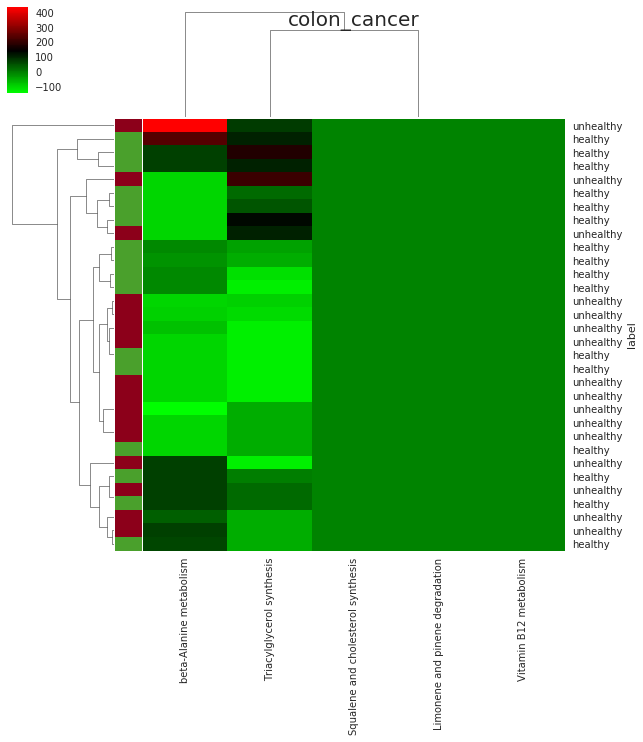

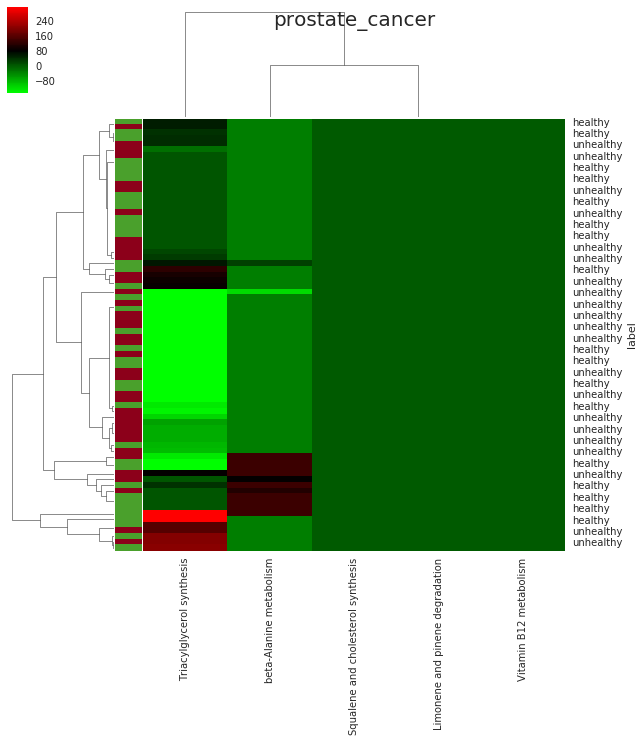

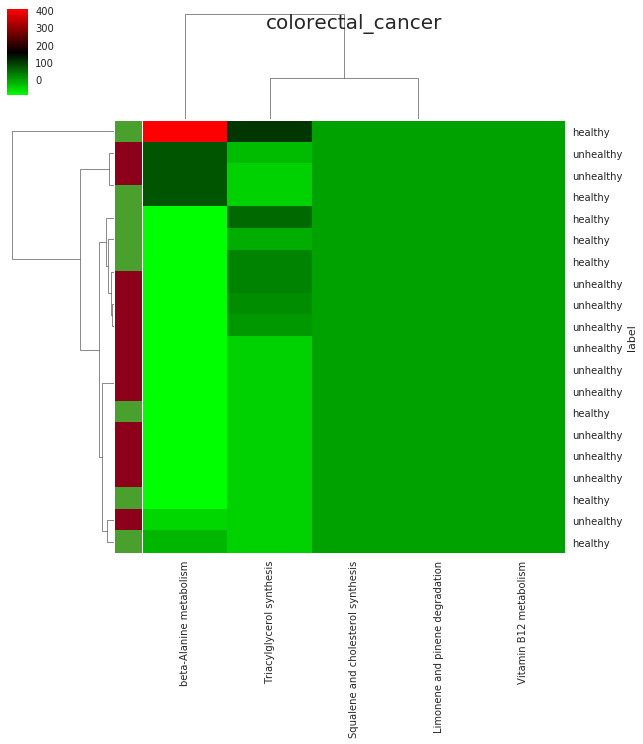

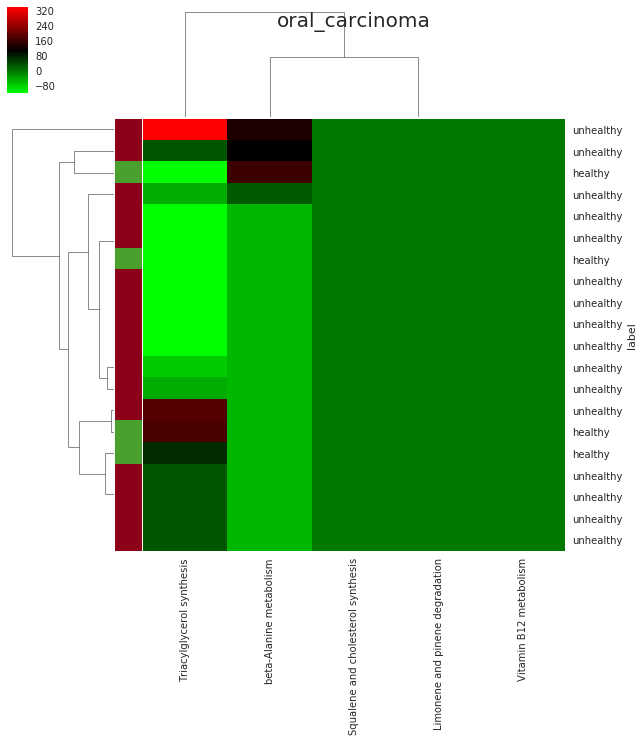

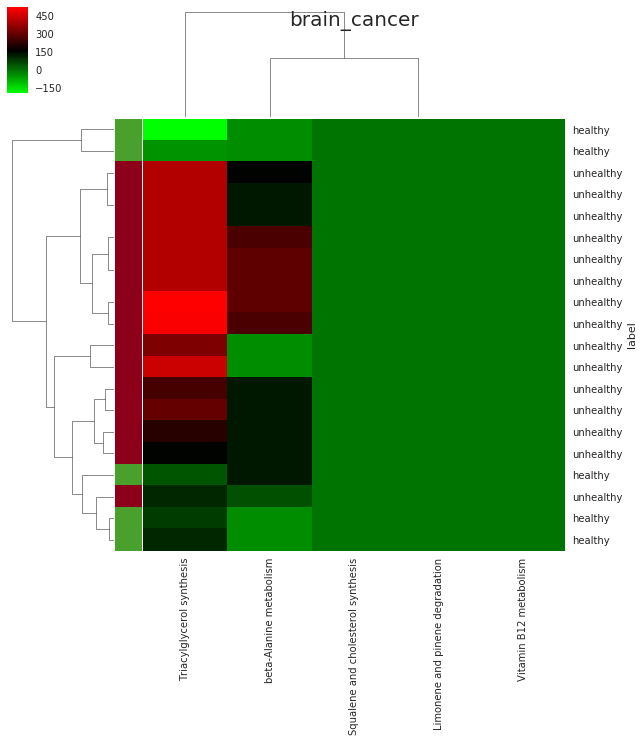

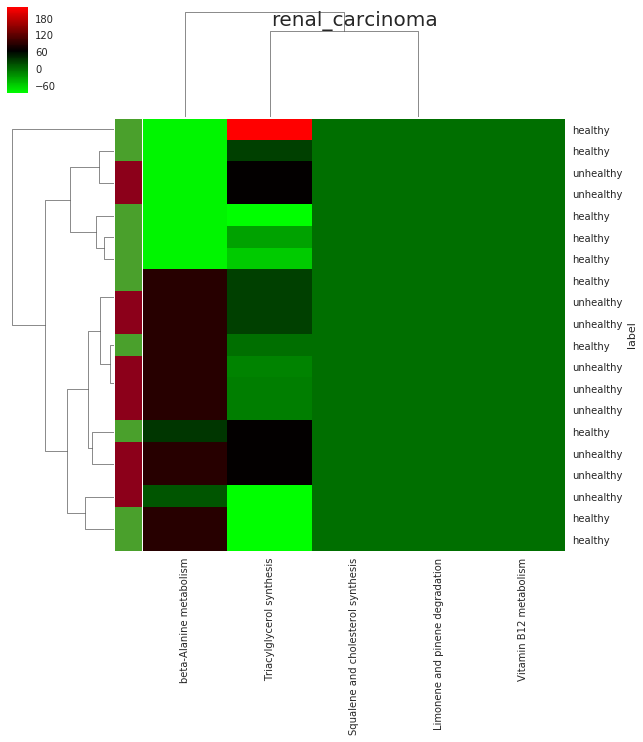

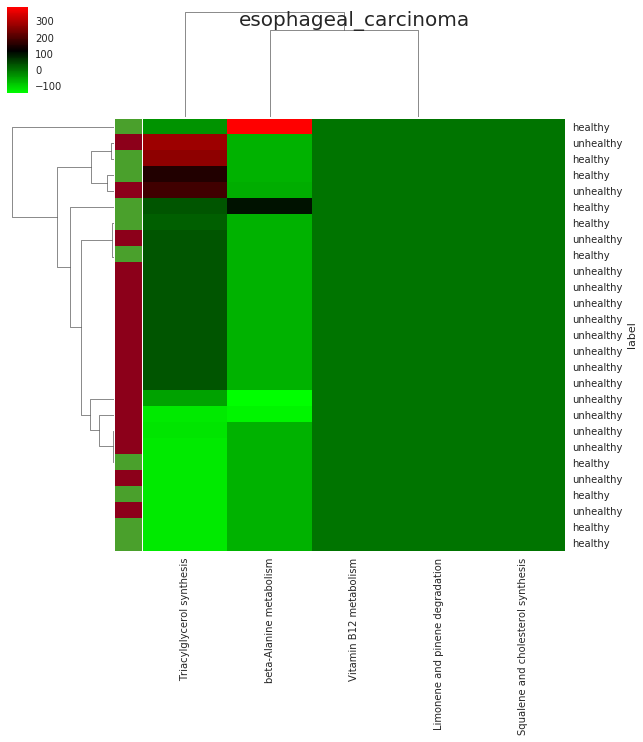

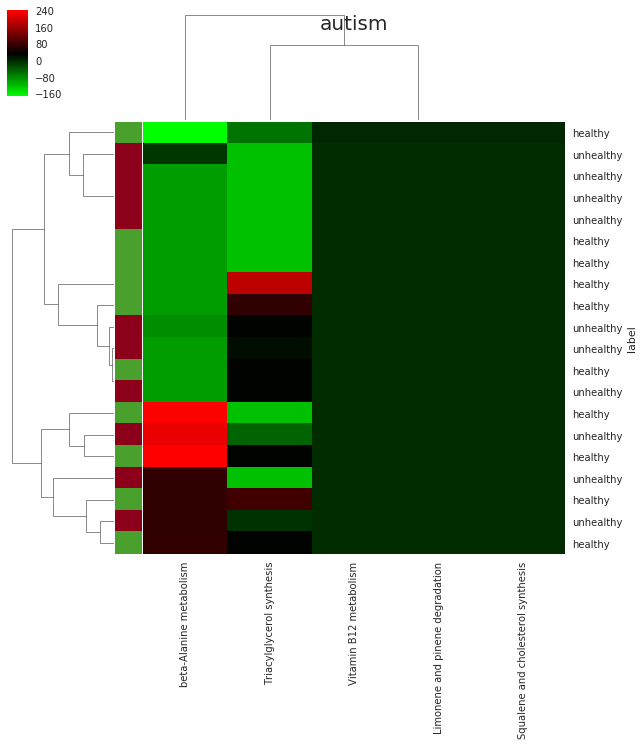

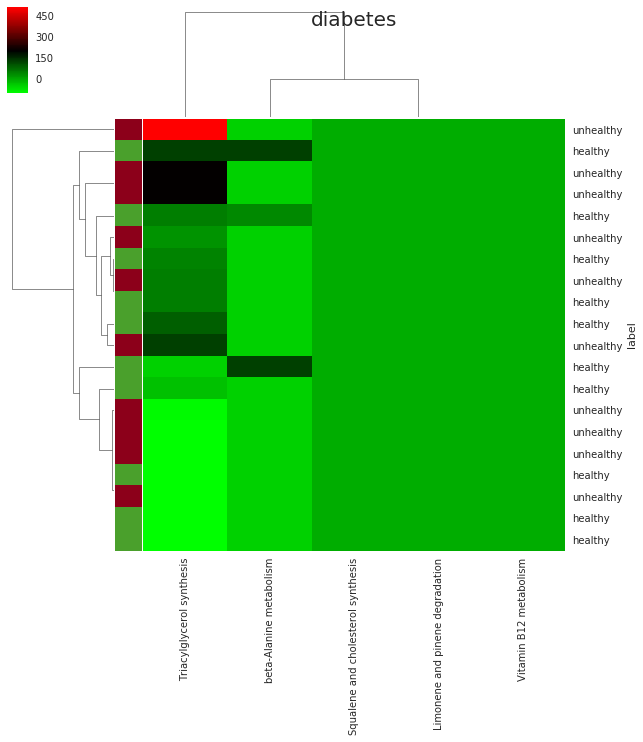

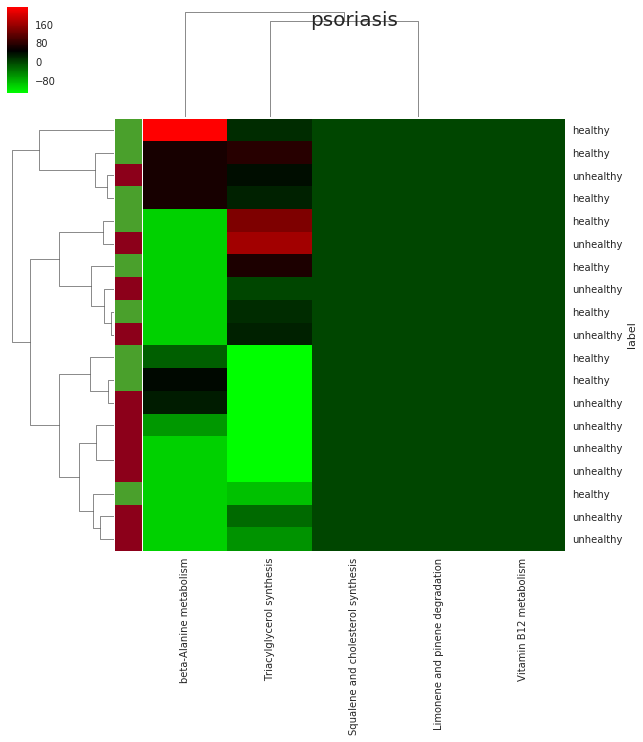

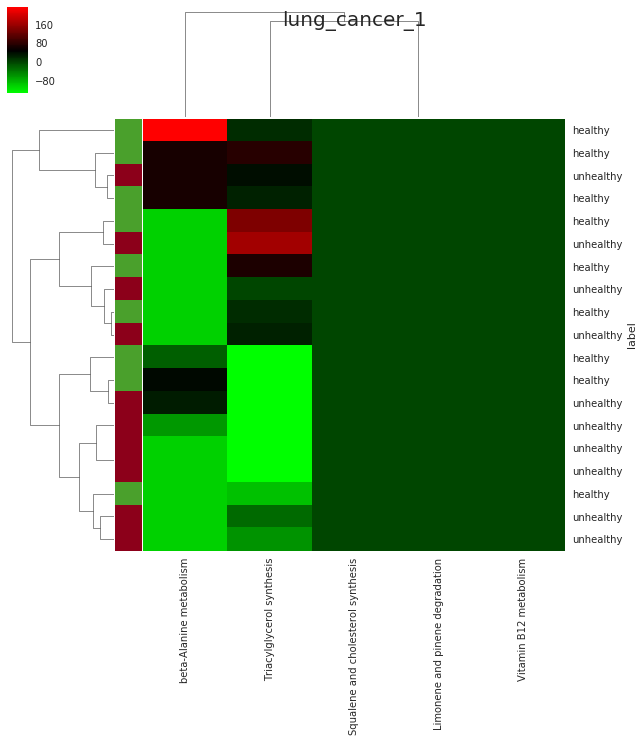

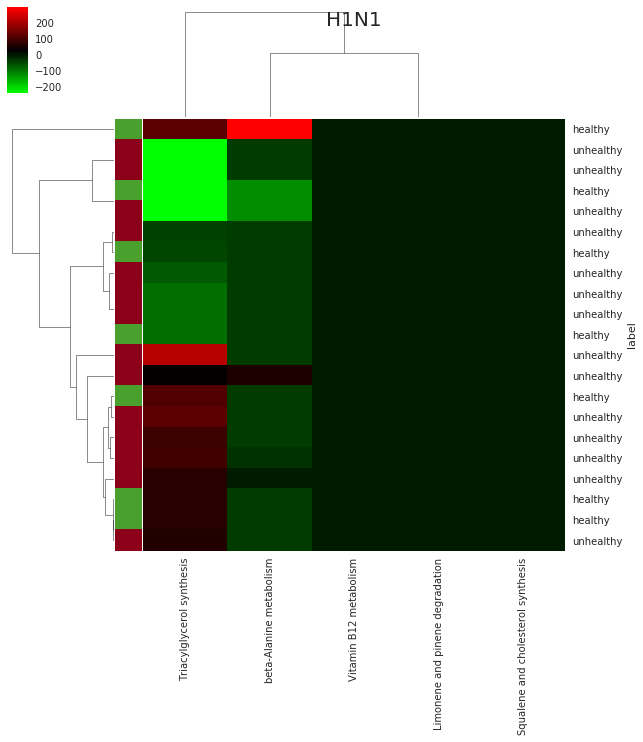

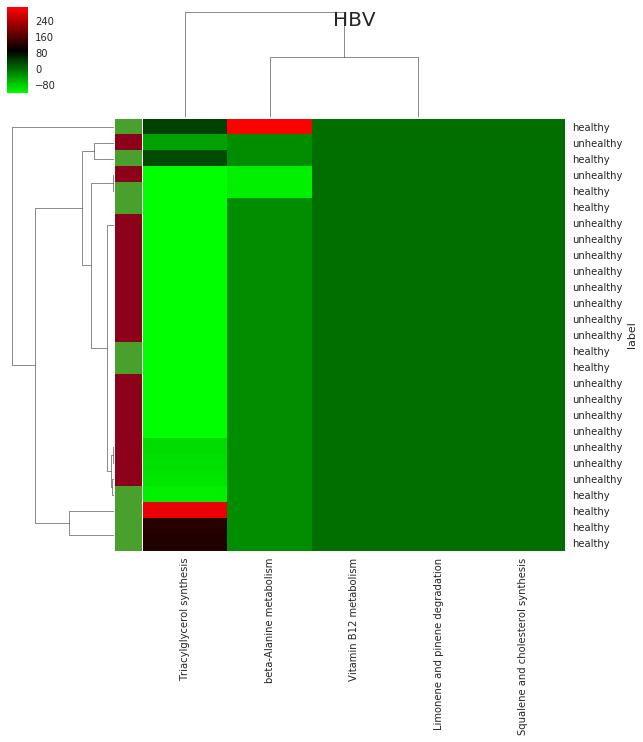

In [25]:
for disease in diseases:
    Xs = X_diffs_h[disease].rename(columns={"index":"label"})[selected_columns+["label"]]
    disease_labels = Xs["label"]
    Xs.set_index("label", inplace=True)
    row_colors = disease_labels.map(lut_per_disease)
    g = sns.clustermap(Xs, row_colors=list(row_colors), cmap=cmap)
    ax = g.ax_heatmap
    ax.set_title(disease, y=1.2, fontsize=20)

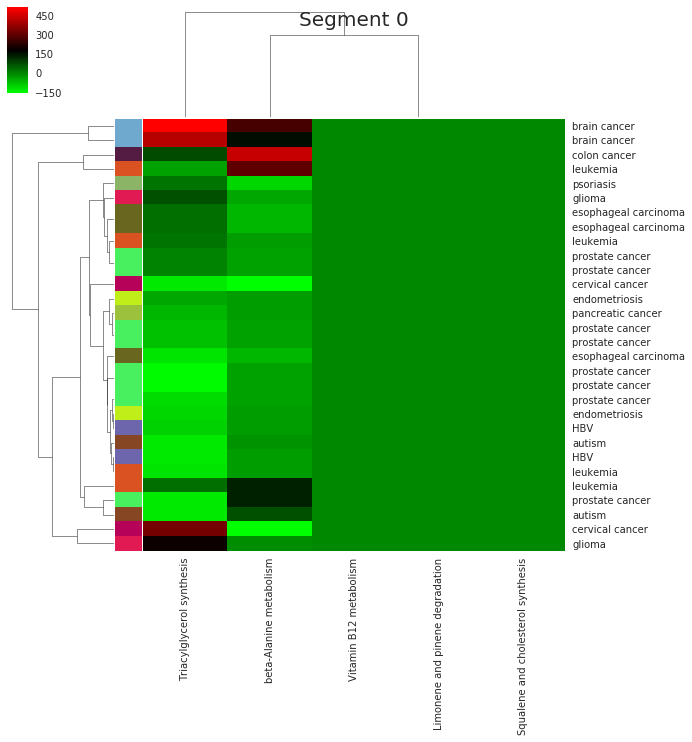

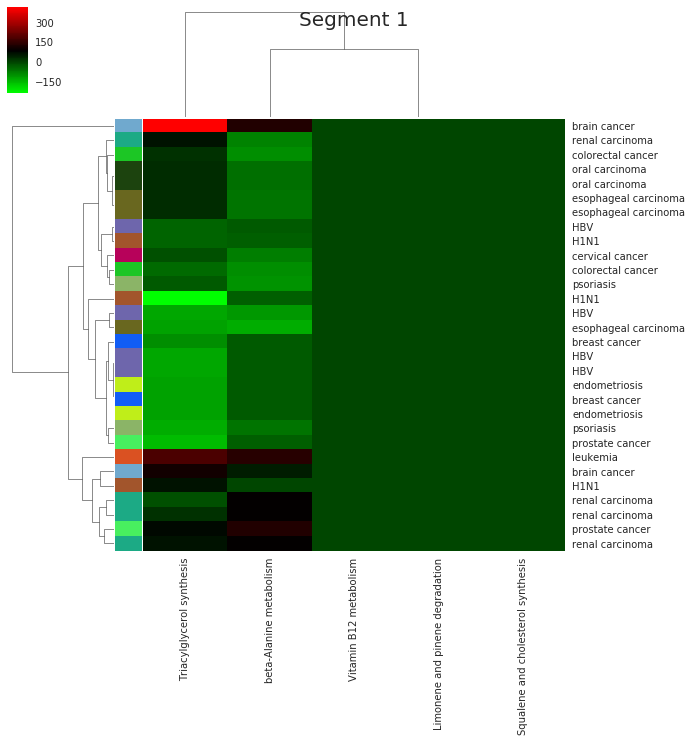

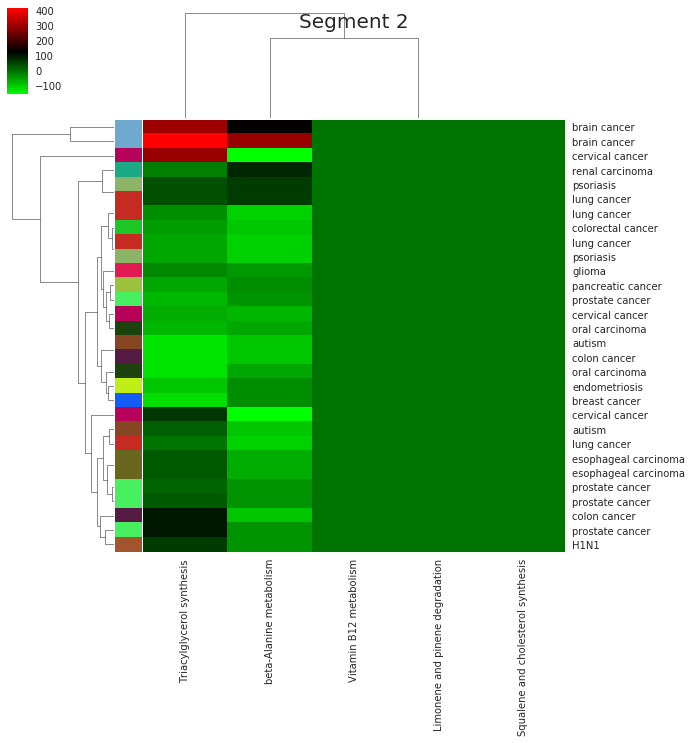

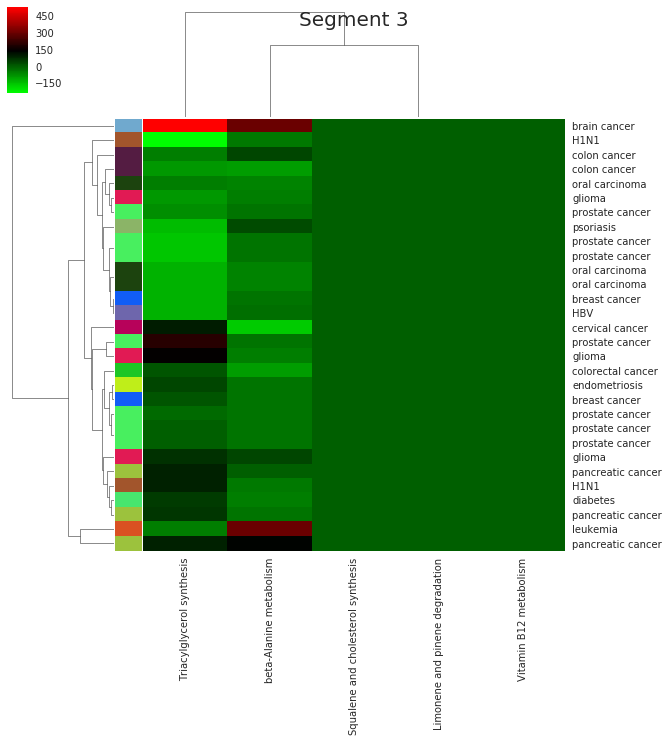

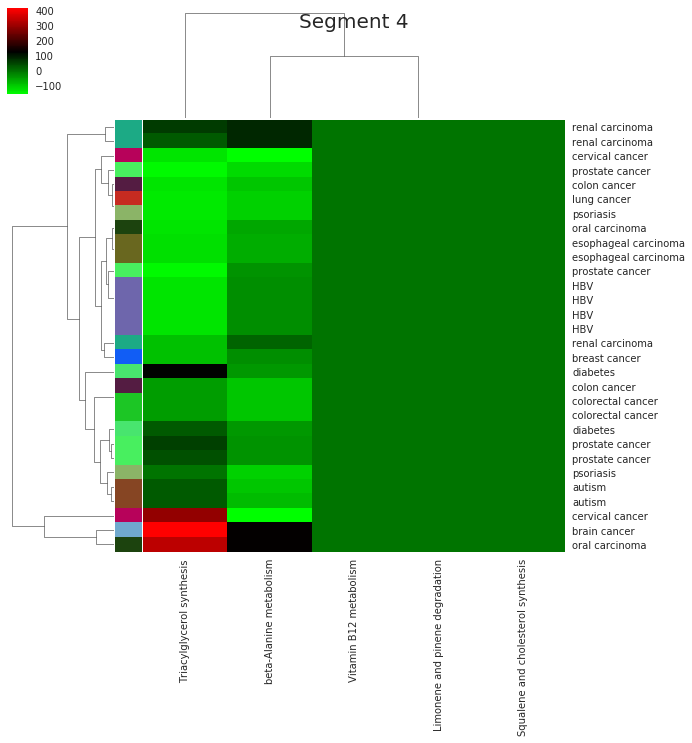

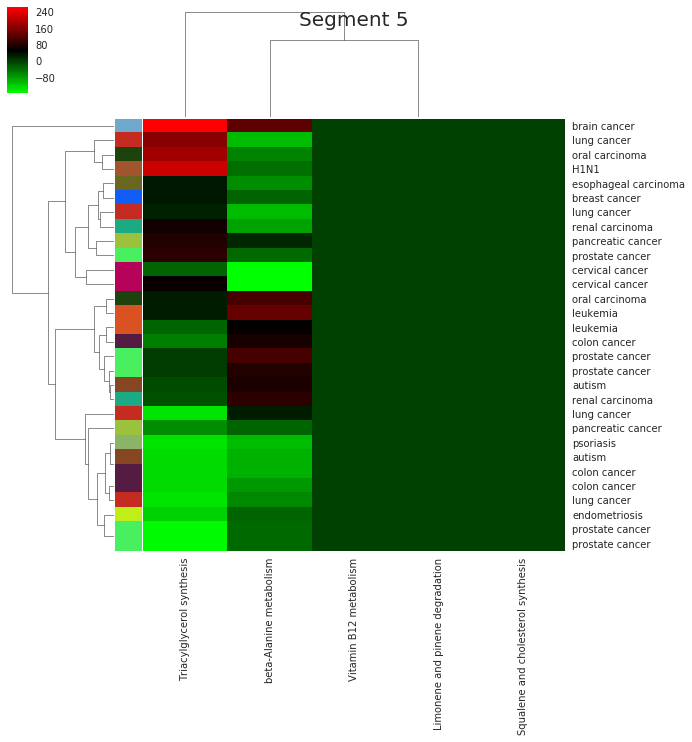

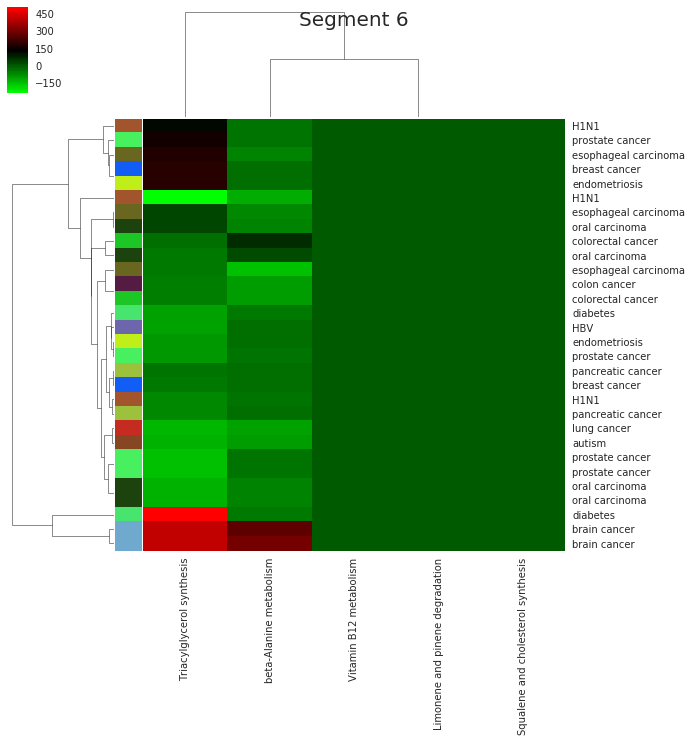

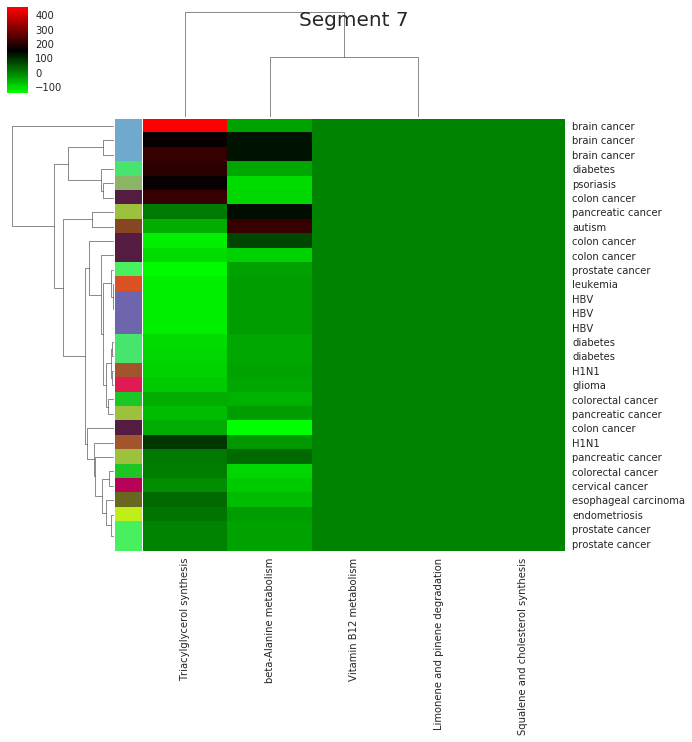

In [26]:
segments = max(int(len(reduced_Xs)/20), 30)
shuffled = reduced_Xs.sample(frac=1)
for i in range(int(len(reduced_Xs)/segments)):
    Xs = shuffled[i*segments:(i+1)*segments]
    disease_labels = Xs.reset_index()["index"]
    row_colors = disease_labels.map(lut)
    g = sns.clustermap(Xs, row_colors=list(row_colors), cmap=cmap)
    ax = g.ax_heatmap
    ax.set_title("Segment {}".format(i), y=1.2, fontsize=20)

In [27]:
disease_labels = reduced_Xs.reset_index()["index"]

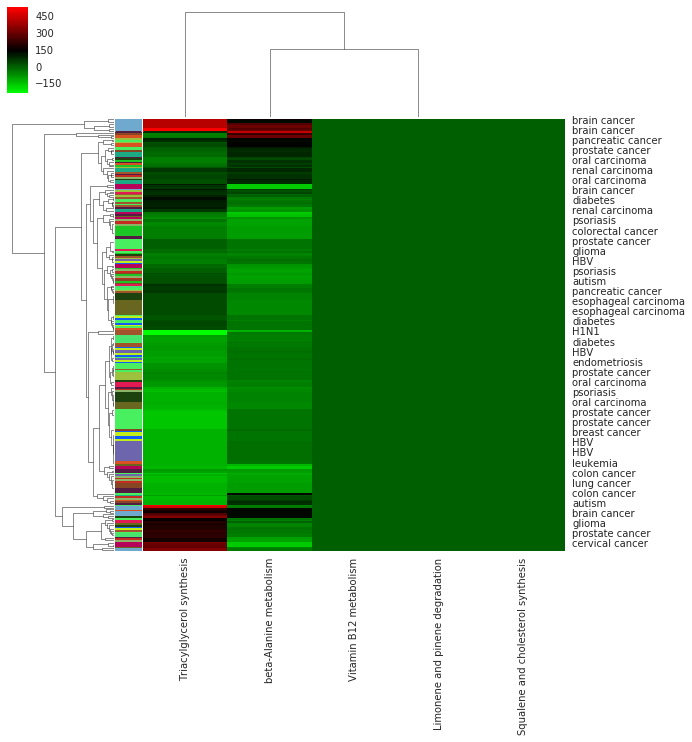

In [28]:
row_colors = disease_labels.map(lut)
g = sns.clustermap(reduced_Xs, row_colors=list(row_colors), cmap=cmap)

## Averaging pathways for each disease (with only 5 significant pathways)

In [26]:
reduced_Xs_averaged = reduced_Xs.groupby(reduced_Xs.index).mean()

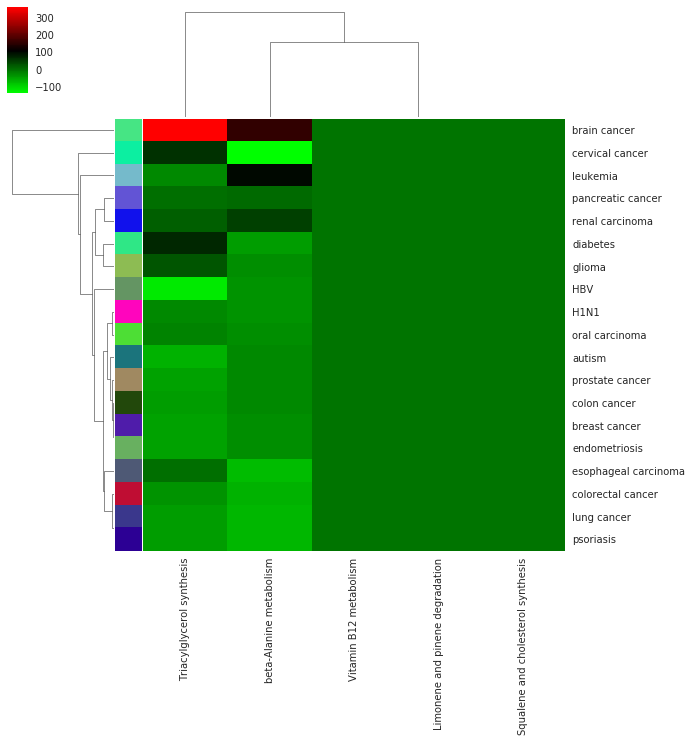

In [27]:
disease_labels = reduced_Xs_averaged.reset_index()["index"]
row_colors = disease_labels.map(lut)
g = sns.clustermap(reduced_Xs_averaged, row_colors=list(row_colors), cmap=cmap)

# Using no diff values

In [ ]:
Xs_nodiff = pd.concat(X_nodiffs.values()).sample(frac=1).rename(columns={"index":"diseases"})

In [ ]:
for disease in diseases:
    try:
        Xs = X_nodiffs_h[disease].rename(columns={"index":"label"})
        Xs.dropna(inplace=True)
        disease_labels = Xs["label"]
        Xs.set_index("label", inplace=True)
        row_colors = disease_labels.map(lut_per_disease)
        g = sns.clustermap(Xs, row_colors=list(row_colors), cmap=cmap)
        ax = g.ax_heatmap
        ax.set_title(disease, y=1.2, fontsize=20)
    except RecursionError:
        print("RecursionError in {}".format(disease))
        continue

## Getting cluster classes

In [ ]:
den = scipy.cluster.hierarchy.dendrogram(g.dendrogram_col.linkage,
                                         labels = reduced_Xs.index,
                                         color_threshold=0.60)
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

clusters = get_cluster_classes(den)

cluster = []
for i in reduced_Xs.index:
    included=False
    for j in clusters.keys():
        if i in clusters[j]:
            cluster.append(j)
            included=True
    if not included:
        cluster.append(None)

reduced_Xs["cluster"] = cluster